In [6]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from rlglue.rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env

In [7]:
def argmax(q_values):
    top = float("-inf") # set top to negative infinity
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = [] # QUESTION: Why do not we add i to ties? ANSWER: Because we add i to ties in the next command

        if q_values[i] == top:
            ties.append(i)

    return np.random.choice(ties)

In [8]:
test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

# make sure np.random.choice is called correctly
np.random.seed(0)
test_array = [1, 0, 0, 1]

assert argmax(test_array) == 0

In [9]:
test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

# set random seed so results are deterministic
np.random.seed(0)
test_array = [1, 0, 0, 1]

counts = [0, 0, 0, 0]
for _ in range(100):
    a = argmax(test_array)
    counts[a] += 1

# make sure argmax does not always choose first entry
assert counts[0] != 100, "Make sure your argmax implementation randomly choooses among the largest values."

# make sure argmax does not always choose last entry
assert counts[3] != 100, "Make sure your argmax implementation randomly choooses among the largest values."

# make sure the random number generator is called exactly once whenver `argmax` is called
expected = [44, 0, 0, 56] # <-- notice not perfectly uniform due to randomness
assert counts == expected

In [10]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation=None):
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (reward - self.q_values[self.last_action]) / self.arm_count[self.last_action]
        
        current_action = argmax(self.q_values)
        self.last_action = current_action
        return current_action

In [11]:
# build a fake agent for testing and set some initial conditions
np.random.seed(1)
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 0.5, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1

action = greedy_agent.agent_step(reward=1)

# make sure the q_values were updated correctly
assert greedy_agent.q_values == [0, 0.5, 0.5, 0, 0]

# make sure the agent is using the argmax that breaks ties randomly
assert action == 2

In [12]:
# build a fake agent for testing and set some initial conditions
np.random.seed(1)
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1

# take a fake agent step
action = greedy_agent.agent_step(reward=1)

# make sure agent took greedy action
assert action == 2

# make sure q_values were updated correctly
assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

# take another step
action = greedy_agent.agent_step(reward=2)
assert action == 2
assert greedy_agent.q_values == [0, 0.5, 2.0, 0, 0]

Python(59868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:03<00:00, 61.47it/s]


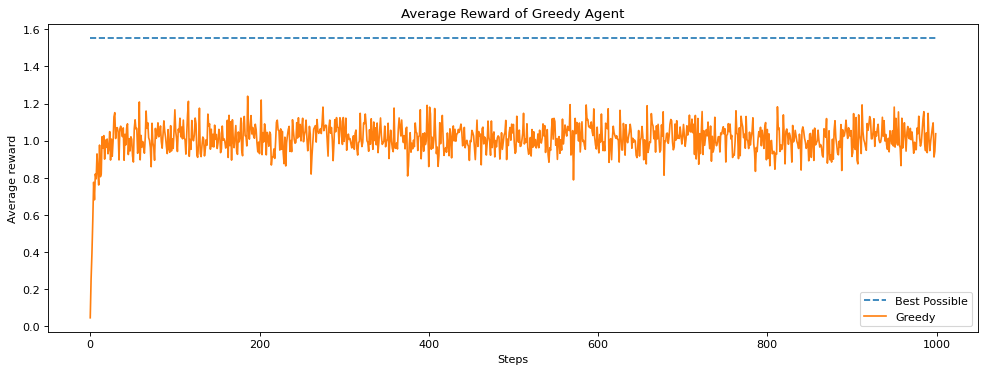

In [13]:
num_runs =  200
num_steps = 1000
env = ten_arm_env.Environment
agent = GreedyAgent
agent_info = {"num_actions": 10}
env_info = {}

rewards = np.zeros((num_runs, num_steps))
average_best = 0

for run in tqdm(range(num_runs)):
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()
    
    average_best += np.max(rl_glue.environment.arms)
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step()
        rewards[run, i] = reward

greedy_scores = np.mean(rewards, axis=0)
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

In [14]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation=None):
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (reward - self.q_values[self.last_action]) / self.arm_count[self.last_action]
        
        random_number = np.random.random()
        if random_number < self.epsilon:
            current_action = np.random.randint(len(self.q_values))
        else:
            current_action = argmax(self.q_values)
        
        self.last_action = current_action
        
        return current_action

In [15]:
# build a fake agent for testing and set some initial conditions
np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.0, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

# given this random seed, we should see a greedy action (action 2) here
action = e_greedy_agent.agent_step(reward=1, observation=0)

# -----------------------------------------------
# we'll try to guess a few of the trickier places
# -----------------------------------------------

# make sure to update for the *last_action* not the current action
assert e_greedy_agent.q_values != [0, 0.5, 1.0, 0, 0], "A"

# make sure the stepsize is based on the *last_action* not the current action
assert e_greedy_agent.q_values != [0, 1, 0.5, 0, 0], "B"

# make sure the agent is using the argmax that breaks ties randomly
assert action == 2, "C"

# -----------------------------------------------

# let's see what happens for another action
np.random.seed(1)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.5, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

# given this random seed, we should see a random action (action 4) here
action = e_greedy_agent.agent_step(reward=1, observation=0)

# The agent saw a reward of 1, so should increase the value for *last_action*
assert e_greedy_agent.q_values == [0, 0.75, 0.5, 0, 0], "D"

# the agent should have picked a random action for this particular random seed
assert action == 4, "E"

In [16]:
np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5
action = e_greedy_agent.agent_step(reward=1, observation=0)

assert e_greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

# manipulate the random seed so the agent takes a random action
np.random.seed(1)
action = e_greedy_agent.agent_step(reward=0, observation=0)

assert action == 4

# check to make sure we update value for action 4
action = e_greedy_agent.agent_step(reward=1, observation=0)
assert e_greedy_agent.q_values == [0, 0.5, 0.0, 0, 1.0]

100%|██████████| 200/200 [00:02<00:00, 80.27it/s]


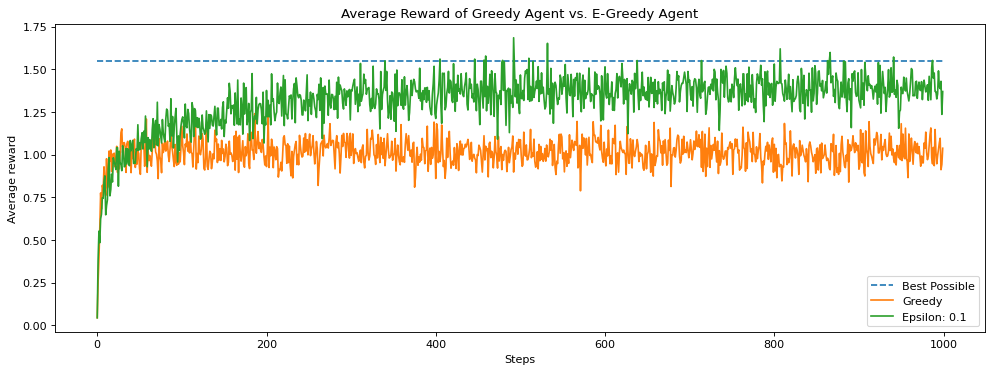

In [17]:
# Plot Epsilon greedy results and greedy results
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_rewards = np.zeros((num_runs, num_steps))

for run in tqdm(range(num_runs)):
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        all_rewards[run, i] = reward

# take the mean over runs
scores = np.mean(all_rewards, axis=0)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. E-Greedy Agent")
plt.plot(scores)
plt.legend(("Best Possible", "Greedy", "Epsilon: 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

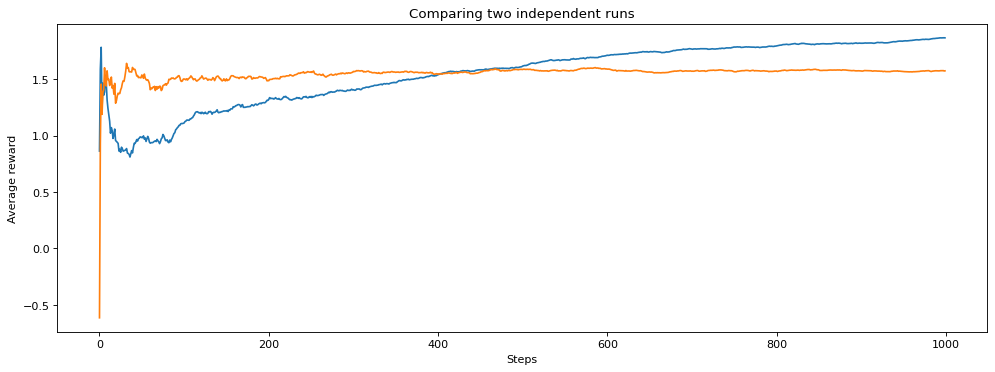

In [18]:
# Plot runs of e-greedy agent
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run) # Here we set the seed so that we can compare two different runs
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    
    plt.plot(averages)

plt.title("Comparing two independent runs")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

In [19]:
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")
    

print()
print()

print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")

Random Seed 1
Exploratory Action
Exploratory Action
Exploratory Action


Random Seed 2
Exploratory Action


100%|██████████| 200/200 [00:02<00:00, 82.14it/s]


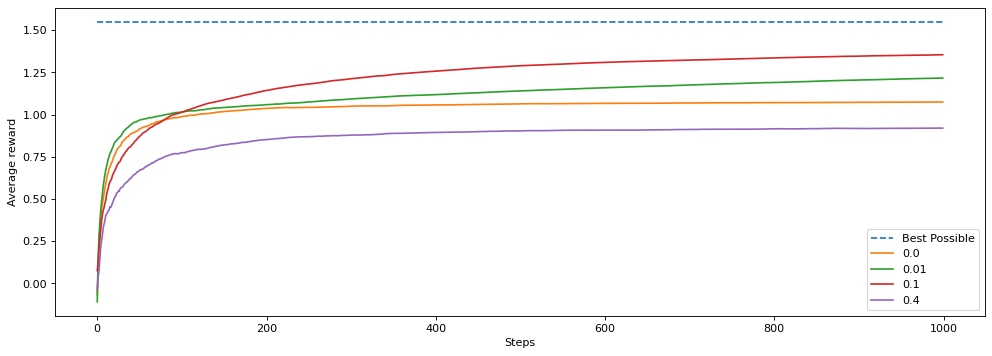

In [20]:
# Experiment code for different e-greedy
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

In [21]:
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        self.arm_count[self.last_action] = self.arm_count[self.last_action] + 1
        self.q_values[self.last_action] = self.q_values[self.last_action] + self.step_size*(reward - self.q_values[self.last_action])

        random_number = np.random.random()
        if random_number < self.epsilon:
            current_action = np.random.randint(len(self.q_values))
        else:
            current_action = argmax(self.q_values)
                    
        self.last_action = current_action
        
        return current_action

In [22]:
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = e_greedy_agent.agent_step(1, 0)
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0], "Check that you are updating q_values correctly using the stepsize."

In [23]:
np.random.seed(0)
# Check Epsilon Greedy with Different Constant Stepsizes
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    
    action = e_greedy_agent.agent_step(1, 0)
    
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0]    

100%|██████████| 200/200 [00:03<00:00, 52.78it/s]
/var/folders/b_/0jy0qw094lxg_fhjn1359cq00000gn/T/ipykernel_59524/2390804734.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.2%}'.format(float(x)) for x in vals])


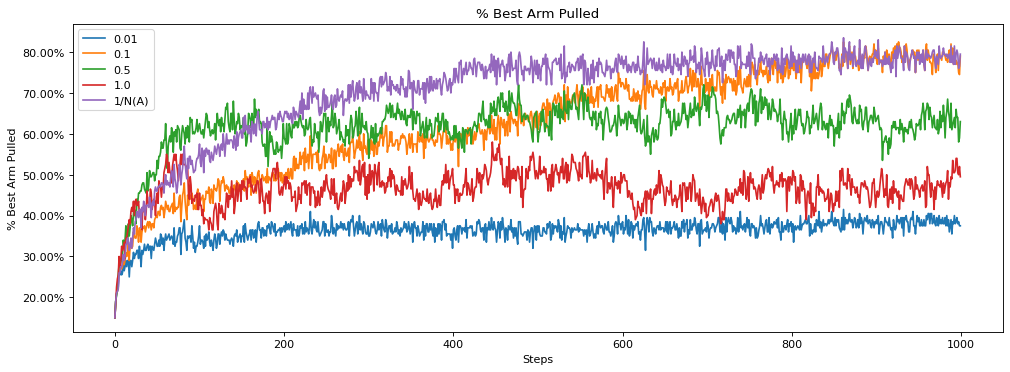

In [27]:
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% Best Arm Pulled")
plt.xlabel("Steps")
plt.ylabel("% Best Arm Pulled")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(float(x)) for x in vals])
plt.show()

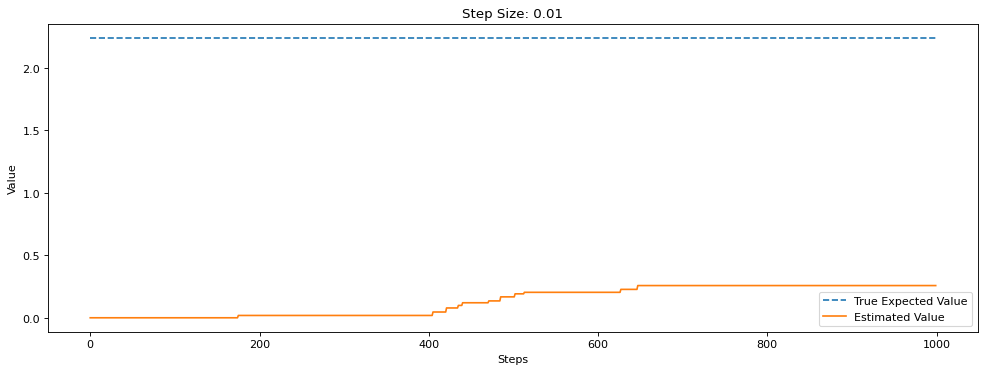

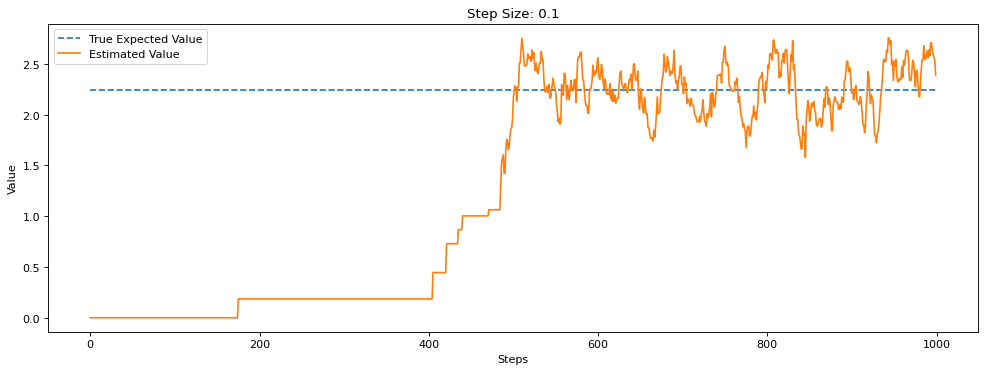

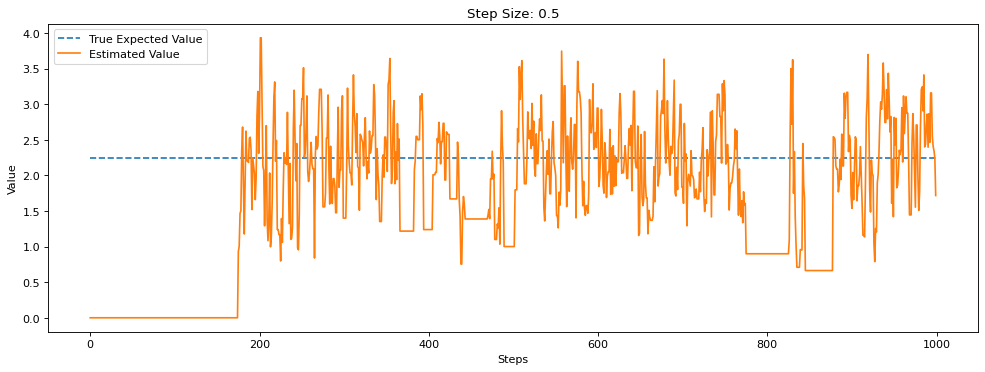

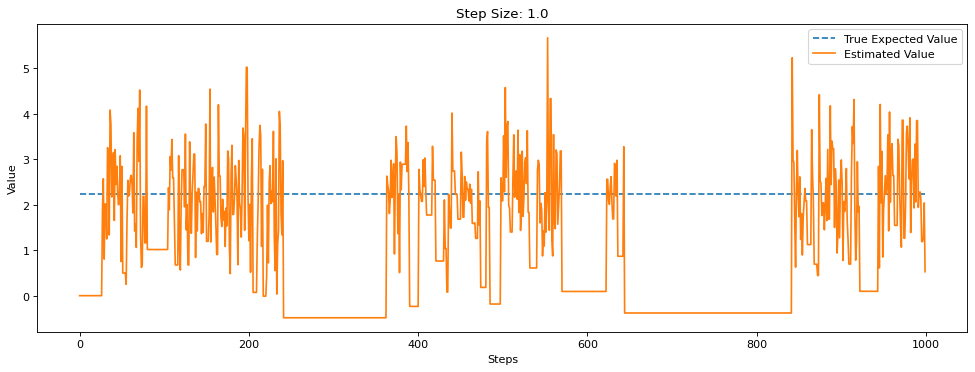

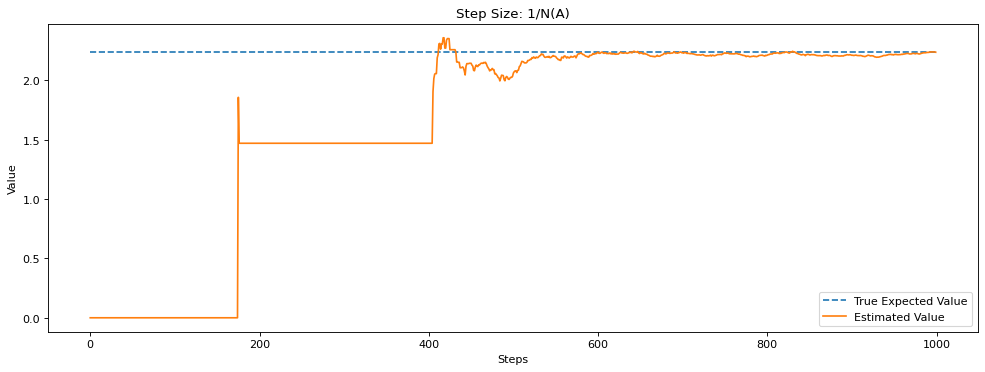

In [28]:
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

100%|██████████| 500/500 [00:28<00:00, 17.50it/s]


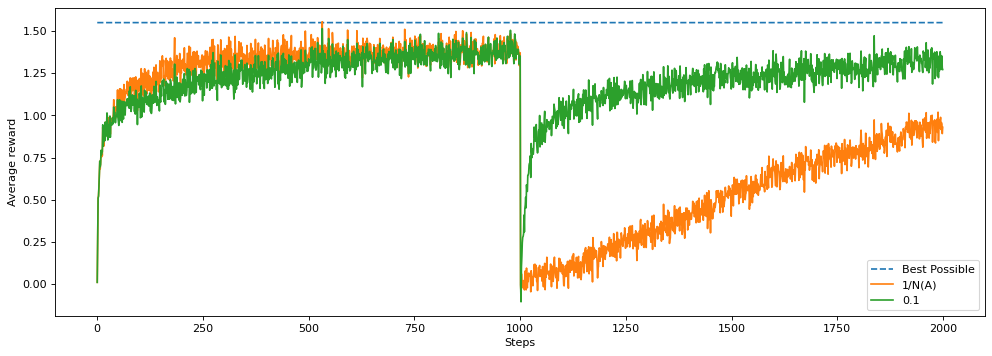

In [29]:
epsilon = 0.1
num_steps = 2000
num_runs = 500
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    rewards = np.zeros((num_runs, num_steps))
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        np.random.seed(run)
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            rewards[run, i] = reward
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        
    plt.plot(np.mean(rewards, axis=0))
plt.legend(["Best Possible", "1/N(A)", "0.1"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()